### Δεδομένα

Data Link: https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020

### Λίγες πληρφορίες για αυτά:

Περιέχουν τις πληροφορίες του Tesla ανά λεπτό.


Επίσης η πληροφορία που μας ενδιαφέρει είναι το close του tesla. Το close είναι η τιμή που διαμορφόθηκε εκείνη τη στιγμή στο Tesla. Το volume είναι η ποσότητα που αγοράστηκε/πουλήθηκε εκείνη τι στιγμή. 

'Αρα στην ουσία το close είναι η τιμή ενός tesla που συναλλάχθηκε εκέίνη τη στιγμή και το volume είναι η ποσότητα που συναλλάχθηκε.

Το open είναι η τιμή που άνοιξε στο Tesla, το low είναι η χαμηλότερη τιμή πώλησης του ανοίγματος και το high η ηψυλότερη τιμή

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow as tf
%matplotlib inline

## Import data

In [2]:
tesla_input_df  = pd.read_csv("TSLA.csv", parse_dates=["Date"], nrows=1440)
tesla_input_df = tesla_input_df.rename(columns={"Date": "time", "Close": "close", "Low":"low", "High":"high", "Volume":"volume"}).copy().drop(columns=["Adj Close"])

tesla_input_df.head()

,time,Open,high,low,close,volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,6866900


In [3]:
tesla_input_df = tesla_input_df.set_index('time')
tesla_input_df.head()

,Open,high,low,close,volume
time,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900


In [4]:
tesla_input_df = tesla_input_df.sort_index()
tesla_input_df.head()

,Open,high,low,close,volume
time,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900


In [5]:
print(tesla_input_df.shape)
print("------------------------")
print(tesla_input_df.info())

(1440, 5)
------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2010-06-29 to 2016-03-17
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1440 non-null   float64
 1   high    1440 non-null   float64
 2   low     1440 non-null   float64
 3   close   1440 non-null   float64
 4   volume  1440 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 67.5 KB
None


In [6]:
tesla_input_df.head()

,Open,high,low,close,volume
time,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900


In [7]:
tesla_input_df.tail()

,Open,high,low,close,volume
time,,,,,
2016-03-11,207.929993,209.419998,205.330002,207.500000,3343100
2016-03-14,212.649994,216.720001,210.639999,215.149994,4065700
2016-03-15,214.270004,218.970001,211.500000,218.339996,3180500
2016-03-16,218.000000,222.580002,217.020004,221.929993,3516700
2016-03-17,221.470001,228.500000,220.000000,226.380005,3782900


## Plot informations

<AxesSubplot:title={'center':'Tesla Price'}, xlabel='time'>

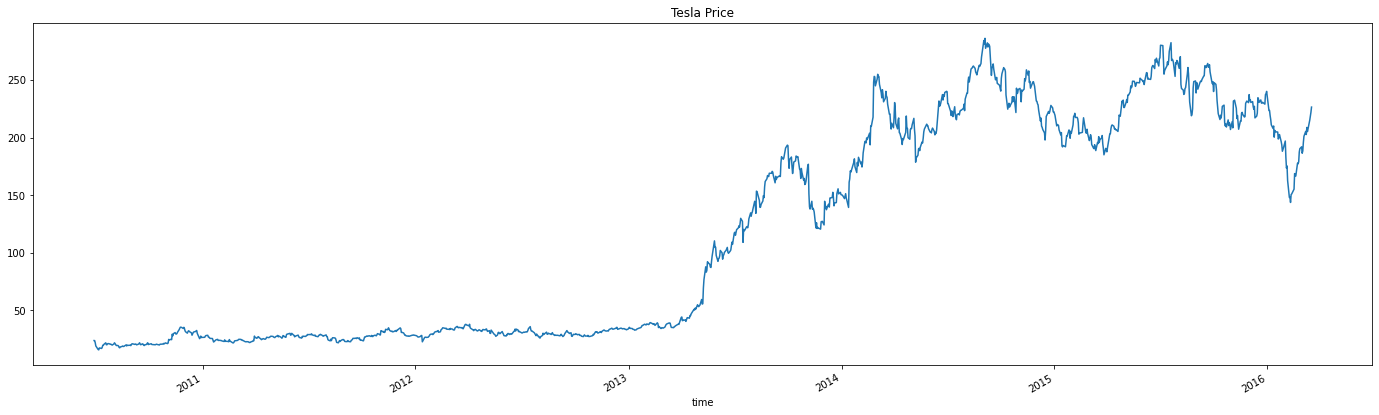

In [8]:
tesla_input_df.close.plot(figsize=(24,7), title="Tesla Price")

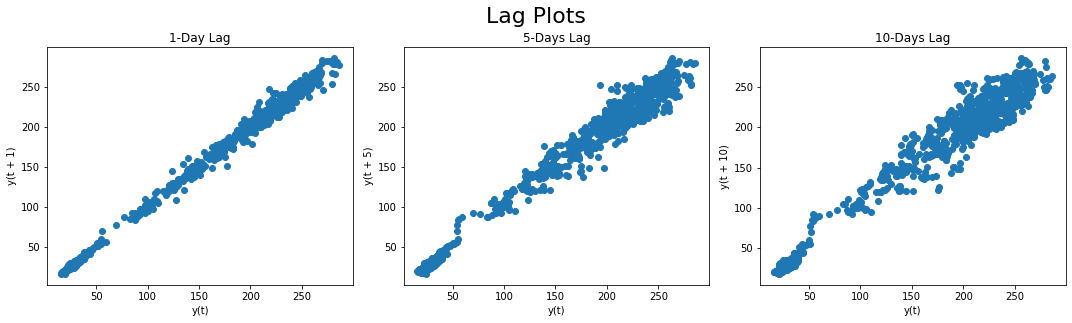

In [9]:
# κάνουμε plot το corelation 
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(tesla_input_df['close'], lag=1) #minute lag
plt.title('1-Day Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(tesla_input_df['close'], lag=5) 
plt.title('5-Days Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(tesla_input_df['close'], lag=10) 
plt.title('10-Days Lag')

plt.tight_layout()

## Pre processing data for LSTM model

In [10]:
tesla_closing_price = tesla_input_df['close'].copy()
tesla_closing_price.head()

time
2010-06-29    23.889999
2010-06-30    23.830000
2010-07-01    21.959999
2010-07-02    19.200001
2010-07-06    16.110001
Name: close, dtype: float64

In [11]:
df_train= tesla_closing_price[:-200].copy()
df_test= tesla_closing_price[-200:].copy()

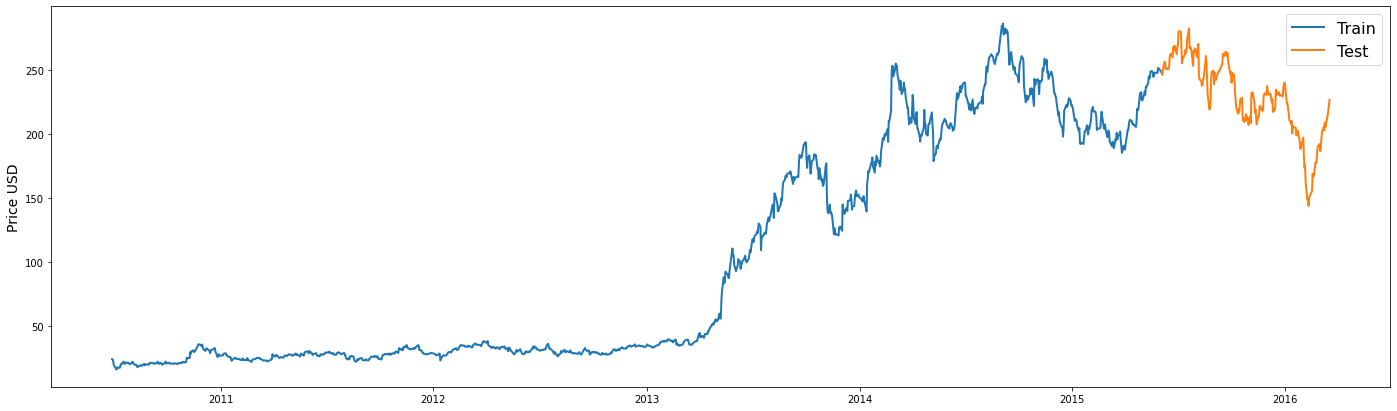

In [12]:
fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [13]:
df_train= df_train.values.reshape(df_train.shape[0],1)
df_test= df_test.values.reshape(df_test.shape[0],1)

In [14]:
df_train.shape

(1240, 1)

In [15]:
"""
Ο λόγος που χωρίζουμε πρώτα τα δεδομένα μας και μετά τα κανονικοποιούμε
είναι διότι αν κάναμε το αντίθετο, όταν θα γινόταν το scaling, θα χρησιμοποιούνταν
(ως σημείο αναφοράς) τα δεδομένα που έχουμε ως training και αυτό θα επηρέαζε τα δεδομένα εκαπίδευσης.
Στην ουσία θα είχαμ "διαρροή" των αποτελεσμάτων του training set
"""
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [16]:
"""
Θα δημιουργήσουμε μια συνάρτηση που θα χωρίζει το datest σε input που θα δέχεται
το μοντέλο και τα label που πρέπει να προβλέπει.

Για παράδειγμα αν τα δεδομένα μας είχαν την μορφή [1, 2, 3, 4, 5, 6]
τότε τα input που θα παίρνει το μοντέλο μας και το αντίστοιχο output , θα ήταν κάπως έτσι:

Input | Output
1, 2      3
2, 3      4
3, 4      5
4, 5      6


Τα LSTMs δέχονται σαν είσοδο δεδομένα 2 διαστάσεων.
Η πρώτη διάσταση είναι ο αριθμός των χρονικών βημάτων, στο παράδειγμα μας είναι 2,
και η δεύτερη διάσταση είναι ο αριθμός των παρατηρήσεων ανά χρονικό βήμα, στο παράδειγμα είναι 1

"""
def dataset_generator_lstm(dataset, look_back=10):
    """
    Συνάρτηση που επιστρέφει όσα περιγράψαμε παραπάνω. Η παράμετρος
    look back προσδιορίζει πόσα προηγούμενα timesteps θα λάβουμε υπόψη
    για να προβλέψουμε το επόμενο timestep.
    Για παράδειγμα αν θέλουμε να προβλέψουμε τι θα γίνει την χρονική στιγμή t+1 (όπου t είναι η τωρινη
    χρονική στιγμή.) με look back ίσο με 10 , τότε θα χρησιμοποιουθούν τα δεδομένα της χρονική στιγμής
    t-9 , t-8, ... , t-1, t-0
    """    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):   
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testΧ: ", testX.shape)
print("testY", testY.shape)

trainX:  (1230, 10, 1)
trainY:  (1230, 1)
testΧ:  (190, 10, 1)
testY (190, 1)


Για το LSTM πρέπει να αναδιαμορφώσoyme την είσοδο ώστε να είναι ένας τρισδιάστατος πίνακας 
[δείγματα , χρονικά βήματα, χαρακτηριστικά]
Δείγματα (Samples): Είναι το len(trainX) , δηλαδή η ποσότητα των data points που έχουμε
Χαρακτηριστικά (Features): Η ποσότητα των χαρακτηριστικών σε κάθε timestep. Στην συγκεκριμένη περίπτωση το χαρακτηριστικό που έχουμε είναι η τιμή του Tesla.  

In [17]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1230, 10, 1)
Shape of testX:  (190, 10, 1)


## Create LSTM model

In [18]:
model = Sequential()

# model.add(LSTM(units = 32, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(units = 32, activation = 'relu', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [19]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = f'./models/best_model_{int(time.time())}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = model.fit(trainX, trainY, batch_size = 32, epochs = 100, 
                    verbose=1, shuffle=False, 
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0149    
Epoch 00001: val_loss improved from inf to 0.19709, saving model to ./models\best_model_1648118560.hdf5
31/31 [==============================] - 2s 18ms/step - loss: 0.0373 - val_loss: 0.1971
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.0192
Epoch 00002: val_loss improved from 0.19709 to 0.05613, saving model to ./models\best_model_1648118560.hdf5
31/31 [==============================] - 0s 10ms/step - loss: 0.0192 - val_loss: 0.0561
Epoch 3/100
25/31 [=======================>......] - ETA: 0s - loss: 0.0105
Epoch 00003: val_loss improved from 0.05613 to 0.00645, saving model to ./models\best_model_1648118560.hdf5
31/31 [==============================] - 0s 10ms/step - loss: 0.0130 - val_loss: 0.0064
Epoch 4/100
28/31 [==========================>...] - ETA: 0s - loss: 0.0046
Epoch 00004: val_loss improved from 0.00645 to 0.00310, saving model to ./models\best_model_1648118560.hdf5


In [20]:
model_from_saved_checkpoint = load_model(checkpoint_path)

## How good is our model?

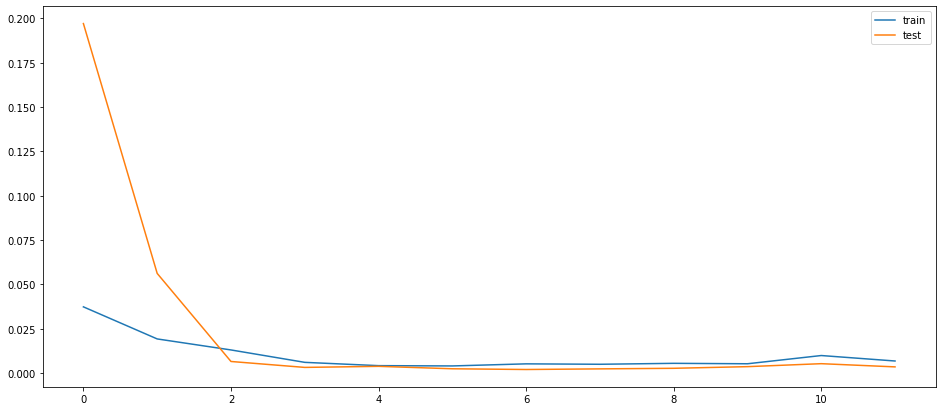

In [21]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_tesla_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_tesla_price_test_data = scaler_test.inverse_transform(predicted_tesla_price_test_data.reshape(testX.shape[0], 1))
test_actual = scaler_test.inverse_transform(testY.reshape(testX.shape[0], 1))

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

print(f"Mean Absolute Error: {mean_absolute_error(predicted_tesla_price_test_data, test_actual)}")
print(f"Mean Square Error: {mean_squared_error(predicted_tesla_price_test_data, test_actual)}")
print(f"r2 score: {r2_score(predicted_tesla_price_test_data, test_actual)}")
print(f"Root Mean Square Error: {rmse(predicted_tesla_price_test_data, test_actual)}")

Mean Absolute Error: 9.721018416385691
Mean Square Error: 134.9669312618495
r2 score: 0.8468562871894035
Root Mean Square Error: 11.617526899553516


In [23]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_tesla_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_tesla_price_train_data = scaler_train.inverse_transform(predicted_tesla_price_train_data.reshape(trainX.shape[0], 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(trainY.shape[0], 1))

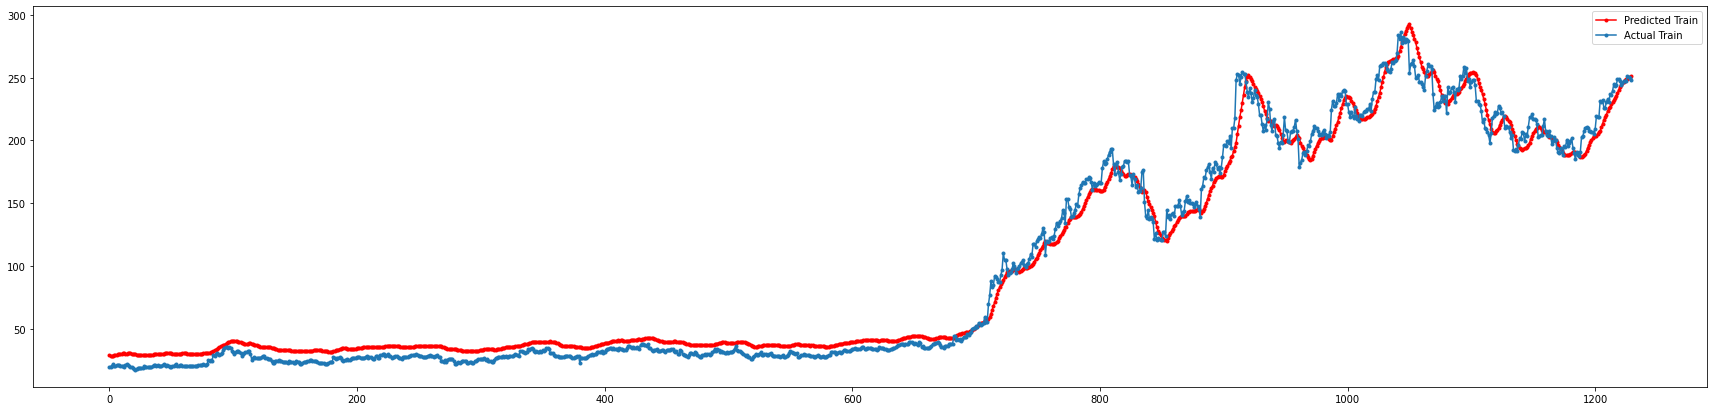

In [24]:
plt.figure(figsize=(30,7))
plt.plot(predicted_tesla_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.legend()
plt.show()

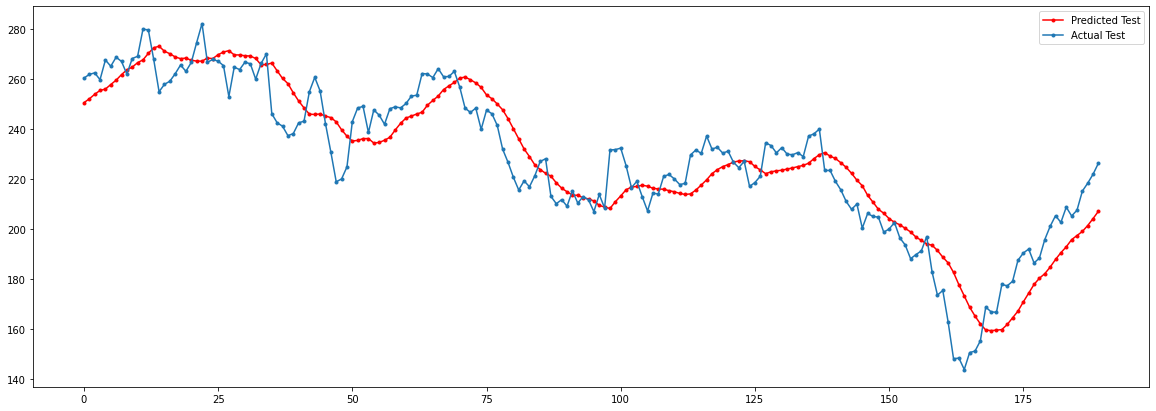

In [25]:
plt.figure(figsize=(20,7))
plt.plot(predicted_tesla_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

In [26]:
testX.shape

(190, 10, 1)

## Forecasting

In [27]:
# για να προβλέψουμε την τιμή της επ΄όμενης μέρας που δεν έχουμε στα δεδομένα μας, θα πρέπει να
# περάσουμε στο μον΄τέλο μας τις look_back μέρες και θα πάρουμε σαν output την επόμενη μέρα
# Όμοια για να πάρουμε την επόμενη μέρα από την αυριανή μέρα, θα δώσουμε σαν input στο μοντέλο μας
# τα δεδομένα των lookback - 1 μερών για να πάρουμε σαν output την μεθαυριανή μέρα
lookback_period = 15
testX_last_days = testX[testX.shape[0] - lookback_period:]
print(testX_last_days.shape)
predicted_days_forecast_price_test_x = []

for i in range(lookback_period):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_days[i:i+1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

predicted_days_forecast_price_test_x = np.array(predicted_days_forecast_price_test_x)
predicted_days_forecast_price_test_x = predicted_days_forecast_price_test_x.flatten()

predicted_tesla_price_test_data = predicted_tesla_price_test_data.flatten()
predicted_tesla_test_concatenated = np.concatenate((predicted_tesla_price_test_data, predicted_days_forecast_price_test_x))


(15, 10, 1)


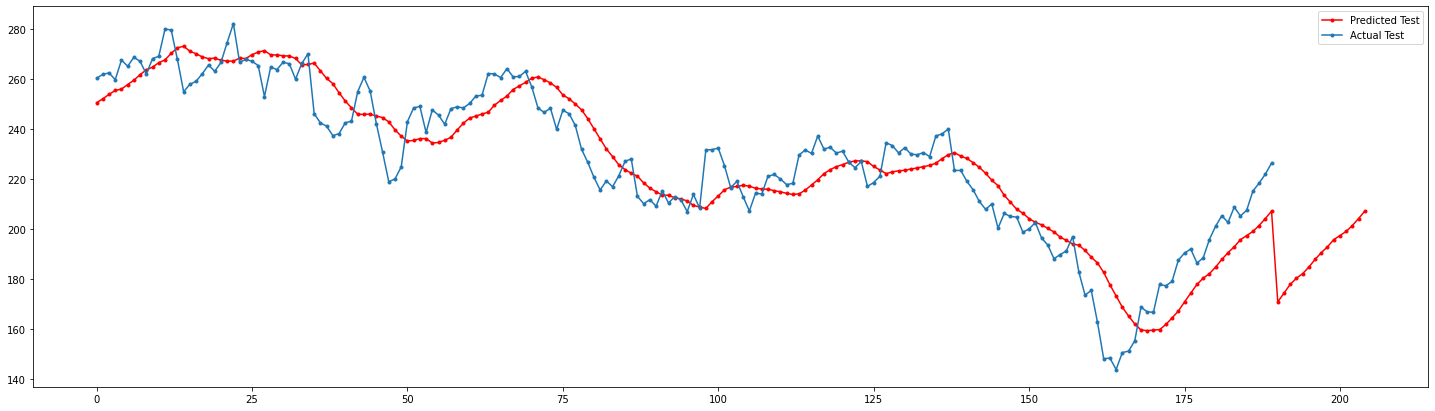

In [28]:
plt.figure(figsize=(25,7))
plt.plot(predicted_tesla_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

## Create dataframe for our trade positions

In [29]:
df_strategy_actual = pd.DataFrame(test_actual)
df_strategy_predicted = pd.DataFrame(predicted_tesla_price_test_data)

df_strategy_actual = df_strategy_actual.rename(columns={0: "close"})
df_strategy_predicted = df_strategy_predicted.rename(columns={0: "close"})

In [30]:
def classify(current, future):
    if future is None:
        return
    """
    Επιστρέφει 1 αν η τιμή στο μέλλον είναι αυξημένη ή
    -1 αν η τιμή στο μέλλον είναι μειωμένη
    """
    if float(future) > float(current):
        return 1
    elif float(future) < float(current):
        return -1

In [31]:
df_strategy_actual['future'] = df_strategy_actual["close"].shift(-1)
df_strategy_predicted['future'] = df_strategy_predicted["close"].shift(-1)
df_strategy_actual['target'] = list(map(classify, df_strategy_actual["close"], df_strategy_actual["future"]))
df_strategy_predicted['target'] = list(map(classify, df_strategy_predicted["close"], df_strategy_predicted["future"]))

frames = [df_strategy_actual, df_strategy_predicted]
result = pd.concat(frames, axis=1, ignore_index=True)
result = result.rename(columns={0: "actual_close", 
                                1:"actual_future_close", 
                                2:"actual_target",
                                3:"predicted_close",
                                4:"predicted_future_close",
                                5:"predicted_target"})
result.dropna(inplace = True)
result["prcnt_change"] = (result['predicted_future_close'] - result['predicted_close'] ) / result['predicted_close']
result.head(30)

,actual_close,actual_future_close,actual_target,predicted_close,predicted_future_close,predicted_target,prcnt_change
0,260.410004,261.890015,1.0,250.570038,252.097778,1.0,0.006097
1,261.890015,262.510010,1.0,252.097778,253.908752,1.0,0.007184
2,262.510010,259.790009,-1.0,253.908752,255.472015,1.0,0.006157
3,259.790009,267.670013,1.0,255.472015,256.015961,1.0,0.002129
4,267.670013,265.170013,-1.0,256.015961,257.837616,1.0,0.007115
5,265.170013,268.790009,1.0,257.837616,259.588074,1.0,0.006789
6,268.790009,267.089996,-1.0,259.588074,261.813904,1.0,0.008574
7,267.089996,262.019989,-1.0,261.813904,263.719788,1.0,0.007280
8,262.019989,268.260010,1.0,263.719788,264.796875,1.0,0.004084
9,268.260010,269.149994,1.0,264.796875,266.607086,1.0,0.006836


## RRL Stock Trading

In [32]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta=0):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta
        
    return grad, S

def train(x, epochs=2000, M=8, commission=0, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    
    print("finished training")
    return theta, sharpes

In [33]:
rets = tesla_input_df['close'].copy().diff()[1:1400]

x = np.array(rets)

N = 1240 
P = 150
x_train = x[:N]
x_test = x[-P:]

std_train = np.std(x_train)
std_test = np.std(x_test)

# mean = np.mean(x_train)

# normalize
x_train = x_train / std_train
x_test = x_test  / std_test

x_test_rrn = x_test[:]

In [34]:
rets.head()

time
2010-06-30   -0.059999
2010-07-01   -1.870001
2010-07-02   -2.759998
2010-07-06   -3.090000
2010-07-07   -0.310001
Name: close, dtype: float64

In [35]:
%%time
np.random.seed(0)
print('start training')
theta, sharpes = train(x_train, epochs=1000, M=10, commission=0, learning_rate=0.5)

start training
finished training
CPU times: total: 32.2 s
Wall time: 32.3 s


Sharpe ratio: 0.08658816403867708


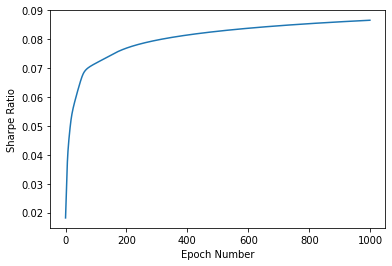

In [36]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio')
print(f"Sharpe ratio: {sharpes[-1]}")

RL model on train data: 103.15022479039376


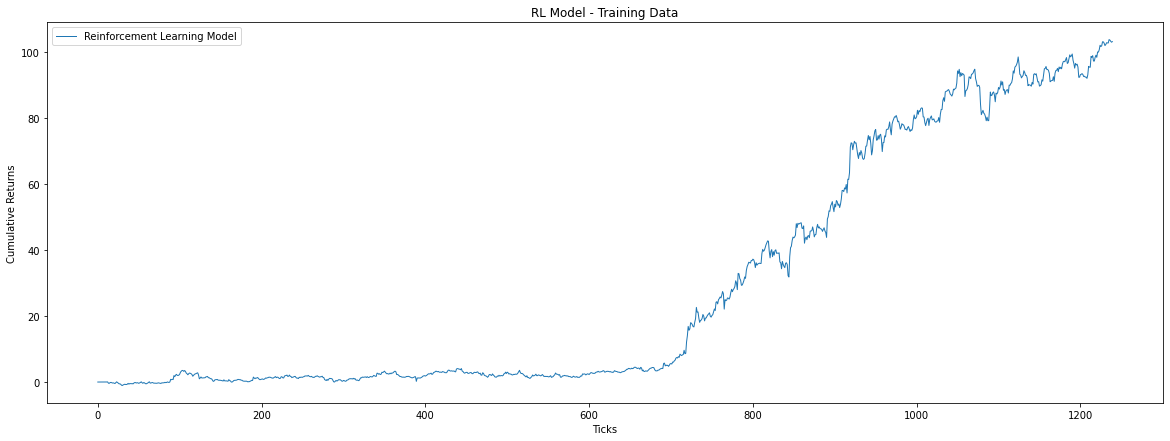

In [37]:
train_returns = returns(positions(x_train, theta), x_train)
test_returns = returns(positions(x_test, theta), x_test)

print(f"RL model on train data: {train_returns.cumsum()[-1]}")

plt.figure(figsize=(20,7))
plt.plot(train_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
# plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model - Training Data");

RL model on test data: 0.13042718607751835
RL model on lstm predictions: -5.423086659053175


Text(0.5, 1.0, 'RL Model - Test Data vs RL Model - LSTM Predictions')

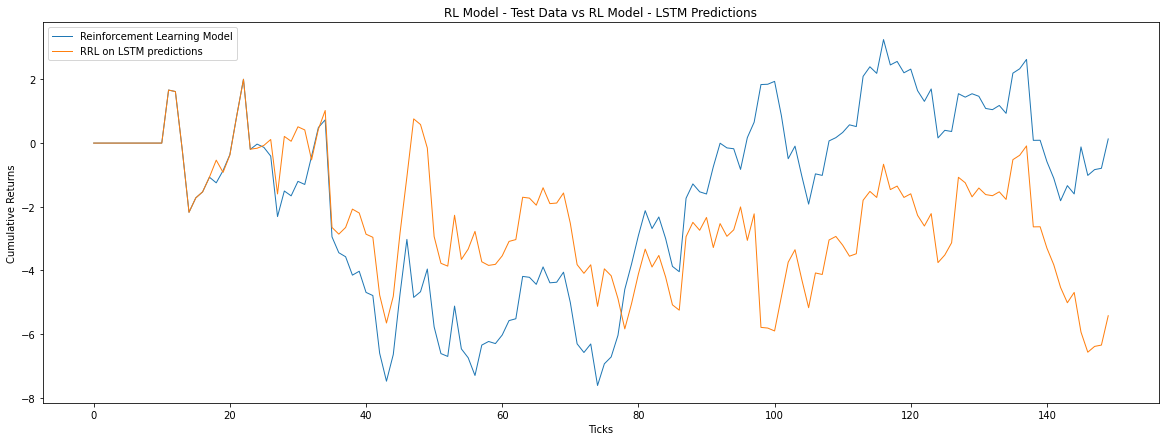

In [38]:
# for lstm predictions
x_lstm_test = np.diff(predicted_tesla_price_test_data)
x_lstm_test = x_lstm_test / np.std(x_lstm_test)
lstm_returns= returns(positions(x_lstm_test, theta), x_test)

print(f"RL model on test data: {test_returns.cumsum()[-1]}")
print(f"RL model on lstm predictions: {lstm_returns.cumsum()[-1]}")

plt.figure(figsize=(20,7))
plt.plot(test_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
# plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.plot(lstm_returns.cumsum(), label="RRL on LSTM predictions", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model - Test Data vs RL Model - LSTM Predictions")

## Let's simulate trading movements

#### RRL

In [40]:
def trade_long(positions, stock_prices, usd=5000, tesla=0, fee=0, plot=True):
    cnt = 0
    total = []
    total.append(usd + tesla * stock_prices[0])
    for index in range(len(positions) - 1): 

        # αγοράζουμε
        if positions[index] > 0 and usd > 0:
            buy = positions[index] * usd 
            tesla = buy / stock_prices[index] + tesla
            usd = usd - buy - (fee * buy)
            cnt += 1
            total.append(usd + tesla * stock_prices.iloc[index])
            continue

        # πουλάμε 
        if positions[index] < 0 and positions[index + 1] < 0 and tesla > 0: 
            sell = tesla
            usd = sell * stock_prices[index] + usd - (fee * tesla)
            tesla = 0
            cnt += 1
            total.append(usd + tesla * stock_prices.iloc[index])
            continue
            
    if plot:
        plt.plot(total)
        plt.xlabel('Trade')
        plt.ylabel('USD')
        plt.title("Portfolio")
        
    print(f"USD: {usd}, tesla: {format(float(tesla), 'f')} Total: {total[-1]} \n#of trades: {cnt}")  
    return usd, tesla, total

USD: 4459.593641806581, tesla: 0.000000 Total: 4459.593641806581 
#of trades: 102


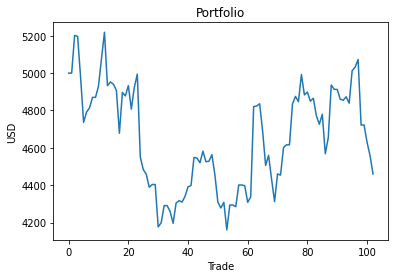

In [41]:
usd, tesla, total = trade_long(positions(x_test_rrn, theta), result['actual_close'].copy())

### Recurrent Reinforcement Learning on LSTM predictions

USD: 0.0, tesla: 20.632200 Total: 4147.897276078775 
#of trades: 96


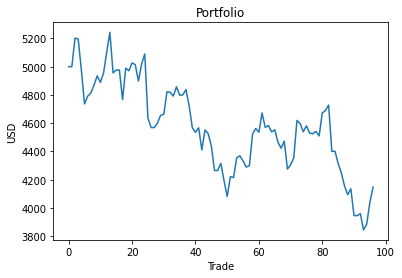

In [42]:
usd, tesla, total = trade_long(positions(x_lstm_test, theta), result['actual_close'].copy())

### Long short-term memory model

USD: 3830.2824311793584, tesla: 5.689958 Total: 5072.627900382995 
#of trades: 98


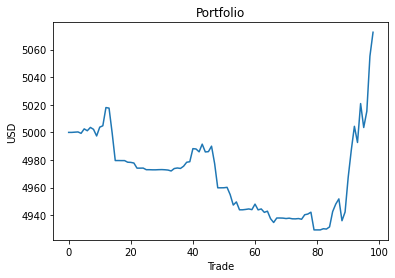

In [43]:
usd, tesla, total = trade_long(result['prcnt_change'], result['actual_close'])